In [1]:
cd ..

C:\Users\Sommer Lab\Documents\Analysis Code


In [2]:
from ImageAnalysis import ImageAnalysisCode
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import pandas as pd
import os

In [87]:
from scipy import ndimage
from skimage.filters import threshold_otsu

In [3]:
####################################
#Set the date and the folder name
####################################
dataRootFolder =r"D:\Dropbox (Lehigh University)\Sommer Lab Shared\Data"
date = '3/9/2024'

ODT_Position = '400'
task = 'Misalign'
task = 'Align'
expectedValues = [None, None]

data_folder = ' '.join([r'Andor/ODT',  ODT_Position, task])
Basler_folder = ' '.join([r'Basler/ODT',  ODT_Position, task])

####################################
#Parameter Setting
####################################
repetition = 3 #The number of identical runs to be averaged.
subtract_burntin = 0
examNum = 5 #The number of runs to exam.
examFrom = None #Set to None if you want to check the last several runs. 
plotPWindow = 5
intermediatePlot = True
uniformscale = 0
rcParams = {'font.size': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9}

variablesToDisplay = [
                    # 'Coil_medB', 
                       'ODT Misalign', 
                       'ODT Position',
                      'ZSBiasCurrent',
                      'VerticalBiasCurrent',
                       'CamBiasCurrent'
                      ]
showTimestamp = False
# variablesToDisplay=None
textY = 1
textVA = 'bottom'

variableFilterList = None
variableFilterList = [
    # 'wait==50', 
    ] # NO SPACE around the operator!

pictureToHide = None
# pictureToHide = [0,1,2,3] # list(range(0,10,2))

subtract_bg = 0
signal_feature = 'narrow' 
signal_width = 10 #The narrower the signal, the bigger the number.
fitbgDeg = 5
angle_deg= 0.5 #rotates ccw

rowstart = 10
rowend = -10
columnstart = 10
columnend = -10

# columnstart = 750
# columnend = 1200

# rowstart =750 #ODT 2675
# rowend = 830
# # rowstart =616 #ODT1675
# # rowend = 651
# rowstart =970 #ODT19001
# rowend = 1070
# # rowstart = 800 #ODT990
# # rowend = 835

# rowstart = 888 #ODT700
# rowend = 923
rowstart = 1032 #ODT400
rowend = 1068

# rowstart = 543 #ODT3400
# rowend = 578

rowstart -= 150
rowend += 150

####################################
####################################
dayfolder = ImageAnalysisCode.GetDataLocation(date, DataPath=dataRootFolder)
dataPath = os.path.join(dayfolder, data_folder)
variableLog_folder = os.path.join(dayfolder, 'Variable Logs')
examFrom, examUntil = ImageAnalysisCode.GetExamRange(examNum, examFrom, repetition)

pPI = 4 if subtract_burntin else 3
params = ImageAnalysisCode.ExperimentParams(date, t_exp = 10e-6, picturesPerIteration=pPI, cam_type = "zyla")

images_array, fileTime, fileFolder = ImageAnalysisCode.LoadSpooledSeriesV2(dataPath, picturesPerIteration=pPI,
                                                               return_fileTime=1, examFrom=examFrom, examUntil=examUntil)

variableLog = ImageAnalysisCode.LoadVariableLog(variableLog_folder)
logTime = ImageAnalysisCode.Filetime2Logtime(fileTime, variableLog)
    
if variableFilterList is not None and variableLog is not None:
    filteredList = ImageAnalysisCode.VariableFilter(logTime, variableLog, variableFilterList)
    images_array = np.delete(images_array, filteredList, 0)
    logTime = np.delete(logTime, filteredList, 0)
    fileFolder = np.delete(fileFolder, filteredList, 0)

if pictureToHide is not None:
    images_array = np.delete(images_array, pictureToHide, 0)
    if logTime is not None:
        logTime = np.delete(logTime, pictureToHide, 0)
        fileFolder = np.delete(fileFolder, pictureToHide, 0)

Number_of_atoms, N_abs, ratio_array, columnDensities, deltaX, deltaY = ImageAnalysisCode.absImagingSimple(images_array, 
                firstFrame=0, correctionFactorInput=1.0,  
                subtract_burntin=subtract_burntin, preventNAN_and_INF=True)

columnDensities = rotate(columnDensities, angle_deg, axes=(1,2), reshape = False)[:, rowstart:rowend, columnstart:columnend]

dx = params.camera.pixelsize_microns/params.magnification
YcolumnDensities = columnDensities.sum(axis=2) * dx / 1e6**2

popts = []
bgs = []
for ydata in YcolumnDensities:
    popt, bg = ImageAnalysisCode.fitMultiGaussian(ydata, dx=dx, 
                                                  subtract_bg=subtract_bg, signal_feature=signal_feature, 
                                                  fitbgDeg=3, amp=1, width=3, denoise=0)
    popts.append(popt)
    bgs.append(bg)
    
# XcolumnDensities = columnDensities.sum(axis=1) * dx / 1e6**2
# poptsX = []
# for xdata in XcolumnDensities:
#     poptx,_ = ImageAnalysisCode.fitSingleGaussian(xdata, dx=dx,
#                                                   subtract_bg=1, signal_feature='wide')
#     poptsX.append(poptx)

results = ImageAnalysisCode.AnalyseFittingResults(popts, logTime=logTime)

if variableLog is not None:
    results.insert(0, 'Folder', fileFolder)
    results = results.join(variableLog.loc[logTime])
# results.to_csv('0305.csv')

	New side imaging


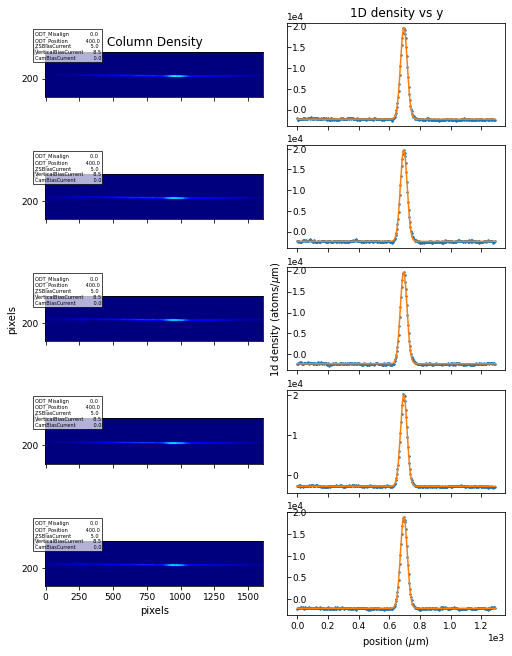

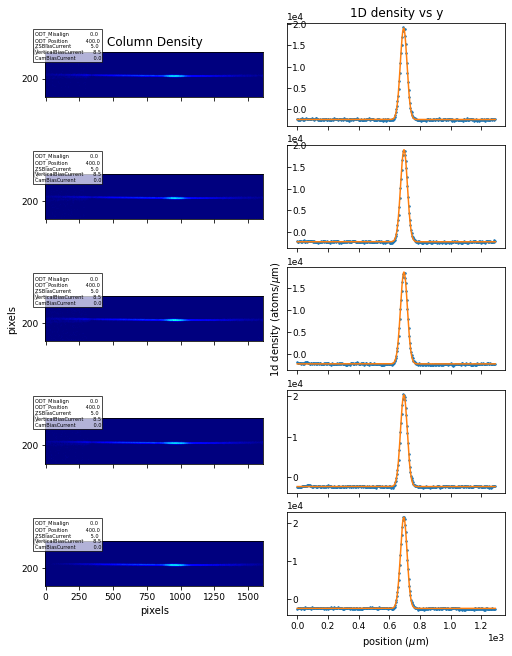

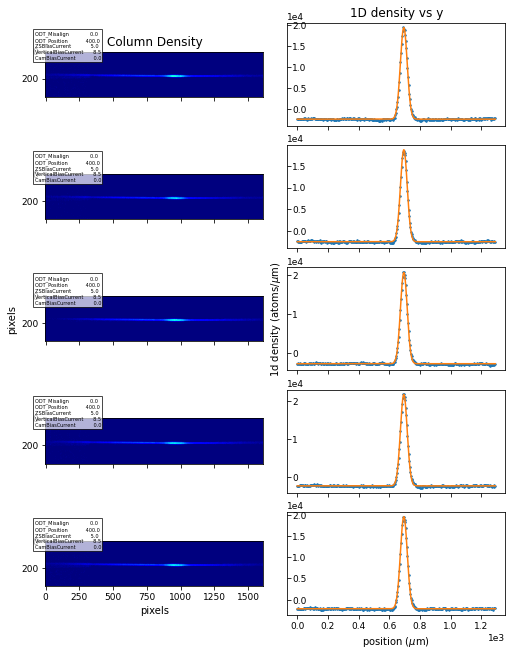

In [4]:
# %%
if intermediatePlot:
    # ImageAnalysisCode.ShowImagesTranspose(images_array, uniformscale=False)
    ImageAnalysisCode.plotImgAndFitResult(columnDensities, popts, bgs=bgs, dx=dx, 
                                          plotPWindow=plotPWindow,
                                          variablesToDisplay = variablesToDisplay,
                                          variableLog=variableLog, logTime=logTime,
                                          textLocationY=0.8, rcParams=rcParams)

    # xx = np.arange(len(imgs_oneD[0]))
    # fig, axes = plt.subplots(fileNo, 1, sharex=True, layout='constrained')
    # for ii in range(fileNo):        
    #     axes[ii].plot(imgs_oneD[ii], '.')
    #     axes[ii].plot(xx, ImageAnalysisCode.Gaussian(xx, *popt_Basler[ii]))
    #     axes[ii].text(0.9,0.8, files[ii], transform=axes[ii].transAxes)

    # c, w = np.array(popt_Basler).mean(axis=0)[1:-1]
    # axes[-1].set(xlim=[c-15*w, c+15*w])
# %%

In [5]:
columnDensities.shape

(15, 336, 1614)

In [17]:
imgFiltered = gaussian_filter(columnDensities, sigma=5, axes=(1,2))

TypeError: gaussian_filter() got an unexpected keyword argument 'axes'

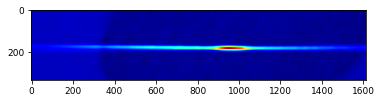

In [16]:
plt.imshow(imgFiltered[0])

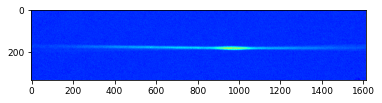

In [12]:
plt.imshow(columnDensities[0])

In [109]:
imgs = columnDensities.copy()

In [110]:
maxCoor = []
imgFiltered = np.zeros_like(columnDensities)
for ii, img in enumerate(imgs):
    imgFiltered[ii] = ndimage.gaussian_filter(img, sigma=10)
    thr = 0.9*(imgFiltered[ii].max() - imgFiltered[ii].min()) + imgFiltered.min()
    img[ imgFiltered[ii] < thr ] = 0
    maxCoor.append( ndimage.center_of_mass(img) )
    # maxCoor.append( np.unravel_index(imgFiltered[ii].argmax(), img.shape) )

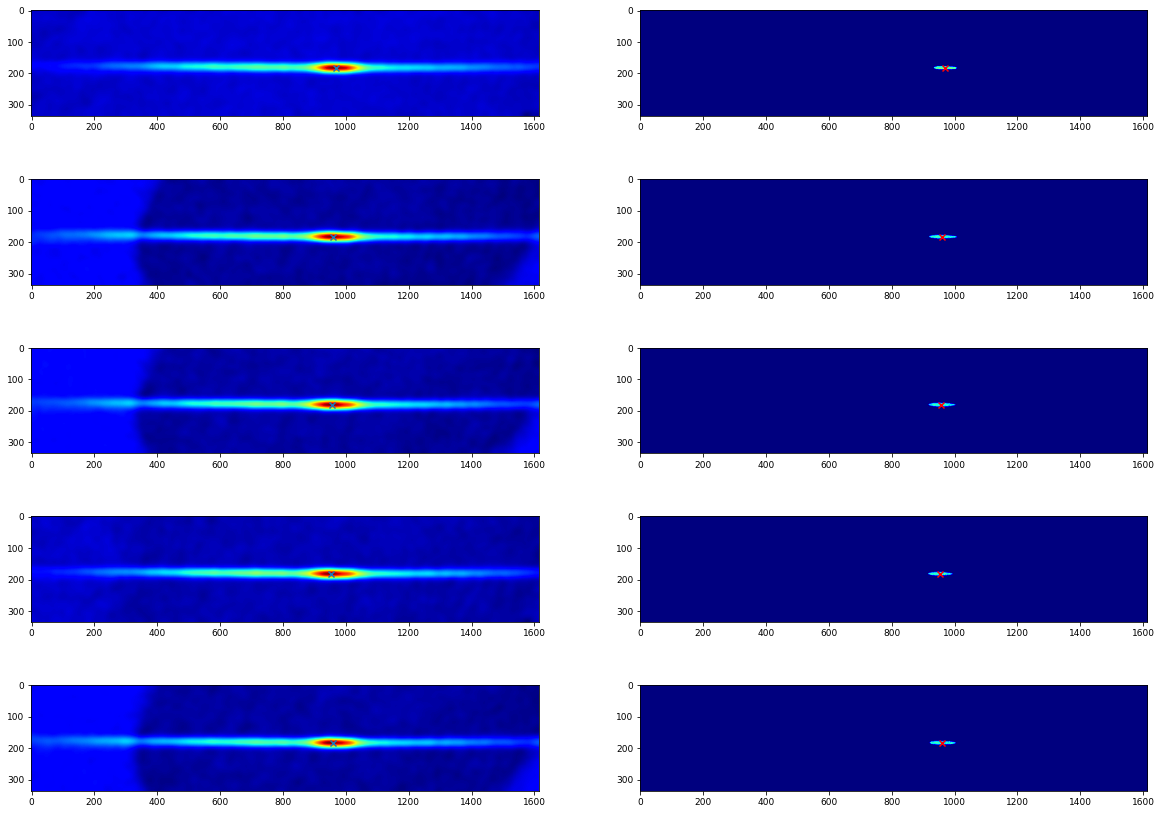

In [111]:
fig, axes = plt.subplots(5,2, figsize=(20,15))
for ii, ax in enumerate(axes):
    ax[0].imshow(imgFiltered[ii])
    ax[0].scatter(*maxCoor[ii][::-1], marker='x')
    
    ax[1].imshow(imgs[ii])
    ax[1].scatter(*maxCoor[ii][::-1], marker='x', c='r')


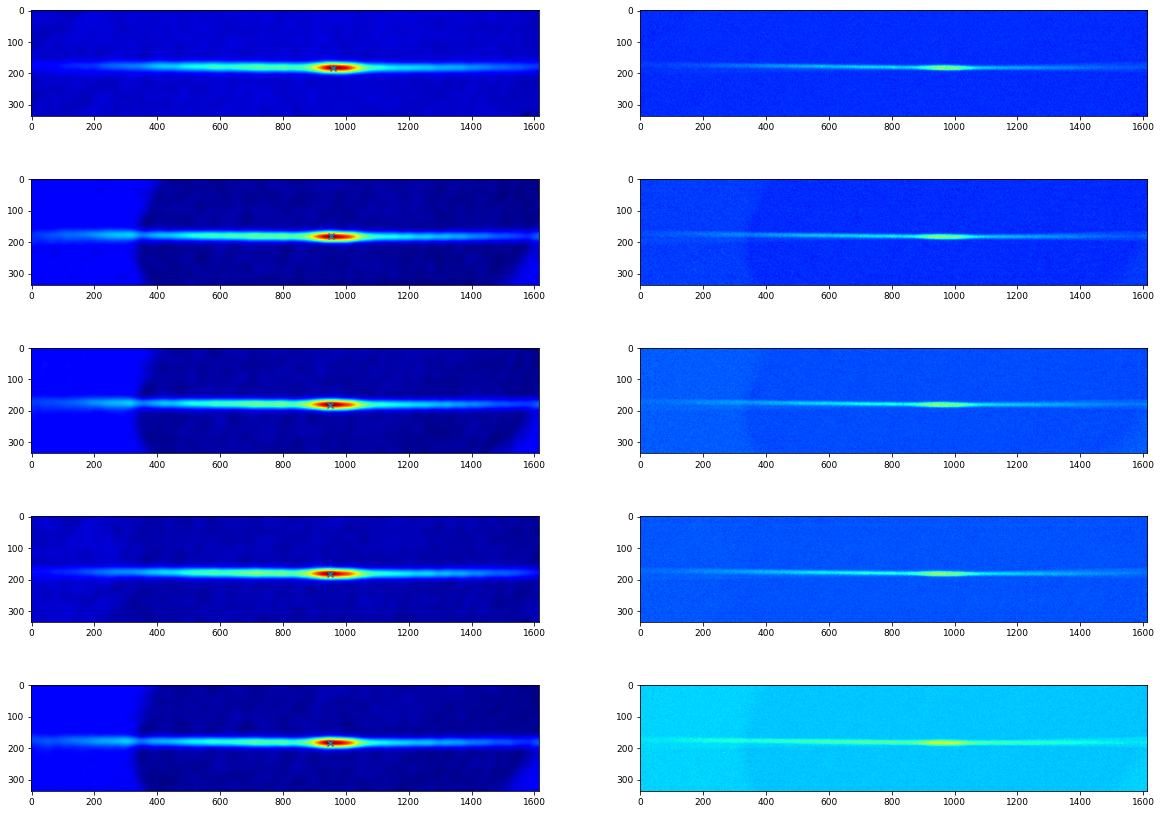

In [81]:
fig, axes = plt.subplots(5,2, figsize=(20,15))
for ii, ax in enumerate(axes):
    ax[0].imshow(imgFiltered[ii])
    ax[0].scatter(*maxCoor[ii][::-1], marker='x')
    
    imgFiltered[ii] > 
    ax[1].imshow(columnDensities[ii])

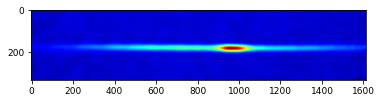

In [58]:
plt.imshow(imgFiltered[0])

In [59]:
imgFiltered[0].max()/1e12

5.377113063320325

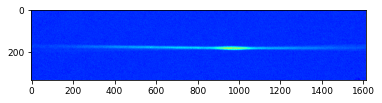

In [60]:
plt.imshow(columnDensities[0])

In [29]:
columnDensities[0].max()/1e12

25.919325669186073

In [20]:
scipy.__version__

'1.7.3'

In [46]:
np.argmax(imgFiltered[0], keepdims=1)

TypeError: _argmax_dispatcher() got an unexpected keyword argument 'keepdims'

In [ ]:
numpy.unravel_index(a.argmax(), a.shape)


In [52]:
np.unravel_index(imgFiltered[0].argmax(), imgFiltered[0].shape)

(182, 960)

In [57]:
plt.rcParams.update(rcParams)

In [90]:
ndimage.center_of_mass(np.array([[0,1,5,0], [1,23,4,5]]))

(0.8461538461538461, 1.4615384615384615)